/home/hqhong/anaconda3/envs/neurosim/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.16666667 0.5        0.83333333]
[0.         0.33333333 0.66666667]


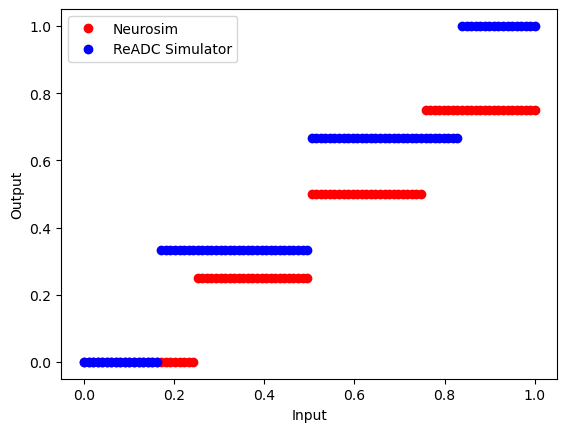

In [1]:
import numpy as np
import torch

#  ADC behavior model supporting uniform and nonuniform quantization of torch NN metrix (Parallel Optimized Version)
def ReNonLinearQuantizeOut(input,ADCprecision,bound=None, out=None):
    if bound is None:
        bound = [0.031, 0.062, 0.094, 0.125, 0.156, 0.188, 0.219, 0.25, 0.281, 0.312, 0.344, 0.375, 0.406, 0.438, 0.469, 0.5, 0.531, 0.562, 0.594, 0.625, 0.656, 0.688, 0.719, 0.75, 0.781, 0.812, 0.844, 0.875, 0.906, 0.938, 0.969, 1.0]
    else:
        bound = bound
    
    if out is None:
        out = [0.016, 0.047, 0.078, 0.109, 0.141, 0.172, 0.203, 0.234, 0.266, 0.297, 0.328, 0.359, 0.391, 0.422, 0.453, 0.484, 0.516, 0.547, 0.578, 0.609, 0.641, 0.672, 0.703, 0.734, 0.766, 0.797, 0.828, 0.859, 0.891, 0.922, 0.953, 0.984]
    else:
        out = out
    minQ = torch.min(input)
    delta = torch.max(input) - minQ
    bound = torch.tensor([torch.finfo(torch.float32).min] + bound + [torch.finfo(torch.float32).max], device=input.device, dtype=input.dtype) * delta + minQ
    out = torch.tensor(out + [1], device=input.device, dtype=torch.float64) * delta + minQ
    idx = torch.searchsorted(bound, input, right=True)-1
    outputs = torch.take(out, idx)
    
    return outputs.to(input.dtype)

def LinearQuantizeOut(x, bit):
    minQ = torch.min(x)
    delta = torch.max(x) - torch.min(x)
    y = x.clone()
    if delta > 0:
        stepSizeRatio = 2.**(-bit)
        stepSize = stepSizeRatio*delta.item()
        index = torch.clamp(torch.floor((x-minQ.item())/stepSize), 0, (2.**(bit)-1))
        y = index*stepSize + minQ.item()

    return y

# ADCprecision -> Boundary (Could be moved into the model) 
bit = 2
bound = np.linspace(0, 1, 2**bit)
out = (bound[:-1] + bound[1:]) / 2 
bound = bound[1:]-out[0]
out = out -out[0]
print(bound)
print(out)

bound = bound.tolist()
out = out.tolist()

# Sample
numbers = np.linspace(0, 1, 100)
numbers = torch.tensor(numbers)

Re_out = ReNonLinearQuantizeOut(numbers,bit,bound,out)
out = LinearQuantizeOut(numbers,bit)

# draw
import matplotlib.pyplot as plt
plt.plot(numbers, out, 'ro', label='Neurosim')
plt.plot(numbers, Re_out, 'bo', label='ReADC Simulator')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

In [5]:
%run test_readc.py

ReADC Quantization Test Suite
Testing linear quantization...
  2-bit: 4 unique levels (max: 4)
  3-bit: 8 unique levels (max: 8)
  4-bit: 16 unique levels (max: 16)
  5-bit: 32 unique levels (max: 32)
✓ Linear quantization tests passed

Testing adaptive quantization...
✓ Adaptive quantization tests passed

Testing Lloyd-Max optimization...
  Optimized 8 levels with MSE optimization
✓ Lloyd-Max optimization tests passed

Testing multi-ADC quantization...
✓ Multi-ADC quantization tests passed

Testing super-resolution quantization...
  Super-resolution differences: 3 out of 100 points
✓ Super-resolution quantization tests passed

Testing noise robustness...
  Testing with 1.0% noise...
    Uniform MSE: 0.001227
    Adaptive MSE: 0.000261
    Super-Resolution MSE: 0.000163
    SR improvement over adaptive: 37.53%
  Testing with 5.0% noise...
    Uniform MSE: 0.001359
    Adaptive MSE: 0.000355
    Super-Resolution MSE: 0.000249
    SR improvement over adaptive: 29.92%
✓ Noise robustness t